# Credit Card Fraud Detection

[Anonymized credit card transactions labeled as fraudulent or genuine](https://www.kaggle.com/mlg-ulb/creditcardfraud).

## Config

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from solucao_exemplo_plotting import (plot_1d_corr_heatmap, 
                                      multiple_histograms_plot,
                                      countplot_independent_ylims)

from scipy.stats import pointbiserialr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [2]:
%matplotlib inline

In [3]:
# exibe todas as colunas do DataFrame
pd.options.display.max_columns = 35

# deixa de utilizar a notação científica
pd.options.display.float_format = lambda x: '%.2f' % x

## Preparação do dataset

In [4]:
df = pd.read_csv('../data/creditcard.csv')

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

É importante já separarmos o dataset de teste, assim garantimos que não iremos tocar nele. Até para a análise dos dados isso pode ser importante, já que nos impede de tomar decisões de feature engineering baseadas nesses dados.

In [6]:
X = df.drop(columns='Class')
y = df['Class']

Aqui vale frisar também que a função `train_test_split` já tem os parâmetros `shuffle` e `stratify` com valores `True` por padrão, caso contrário teríamos que setá-los explicitamente.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

In [8]:
print('Tamanho dos datasets:', (len(y_train), len(y_test)))

Tamanho dos datasets: (199364, 85443)


Vamos juntar as features com o target para analisá-los em um dataframe de treino unificado.

In [9]:
train_idx = y_train.index.sort_values()
df_train = df.loc[train_idx]

## Análise Exploratória Express

In [10]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0
6,4.00,1.23,0.14,0.05,1.20,0.19,0.27,-0.01,0.08,0.46,-0.10,-1.42,-0.15,-0.75,0.17,0.05,-0.44,0.00,-0.61,-0.05,-0.22,-0.17,-0.27,-0.15,-0.78,0.75,-0.26,0.03,0.01,4.99,0
7,7.00,-0.64,1.42,1.07,-0.49,0.95,0.43,1.12,-3.81,0.62,1.25,-0.62,0.29,1.76,-1.32,0.69,-0.08,-1.22,-0.36,0.32,-0.16,1.94,-1.02,0.06,-0.65,-0.42,-0.05,-1.21,-1.09,40.80,0


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199364 entries, 1 to 284806
Data columns (total 31 columns):
Time      199364 non-null float64
V1        199364 non-null float64
V2        199364 non-null float64
V3        199364 non-null float64
V4        199364 non-null float64
V5        199364 non-null float64
V6        199364 non-null float64
V7        199364 non-null float64
V8        199364 non-null float64
V9        199364 non-null float64
V10       199364 non-null float64
V11       199364 non-null float64
V12       199364 non-null float64
V13       199364 non-null float64
V14       199364 non-null float64
V15       199364 non-null float64
V16       199364 non-null float64
V17       199364 non-null float64
V18       199364 non-null float64
V19       199364 non-null float64
V20       199364 non-null float64
V21       199364 non-null float64
V22       199364 non-null float64
V23       199364 non-null float64
V24       199364 non-null float64
V25       199364 non-null float64
V26  

Já que a maioria das features foram geradas com PCA, a correlação entre elas será baixa.
Vamos então analisar a correlação das features com o target `Class`.

Enquanto as features são contínuas, o target é binário. Para correlação entre uma variável contínua e uma binária, utilizaremos o coeficiente de correlação [Ponto Biserial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html).

In [12]:
def point_biserial_corr(binary_series, continuous_df):
    corr = {}
    for col_name in continuous_df:
        corr[col_name] = pointbiserialr(binary_series, 
                                        continuous_df[col_name]).correlation
    
    return pd.Series(corr, name=f"Correlation with '{binary_series.name}'")

In [13]:
corr = point_biserial_corr(y_train, X_train)

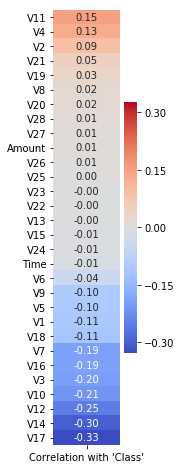

In [14]:
plot_1d_corr_heatmap(corr)


### Class

In [15]:
df_train['Class'].value_counts()

0    199019
1       345
Name: Class, dtype: int64

### Time

Vamos verificar se a coluna `Time` não deveria ser `int`:

In [16]:
df_train['Time'].apply(float.is_integer).all()

True

In [17]:
def time_to_int(dataframe):
    df_copy = dataframe.copy()
    df_copy['Time'] = df_copy['Time'].astype(int)
    return df_copy

In [18]:
df_train = time_to_int(df_train)

In [19]:
n_time_bins = 24
time_bins = range(0, 
                  df_train['Time'].max(), 
                  df_train['Time'].max() // n_time_bins)
list(time_bins)

[0,
 7199,
 14398,
 21597,
 28796,
 35995,
 43194,
 50393,
 57592,
 64791,
 71990,
 79189,
 86388,
 93587,
 100786,
 107985,
 115184,
 122383,
 129582,
 136781,
 143980,
 151179,
 158378,
 165577,
 172776]

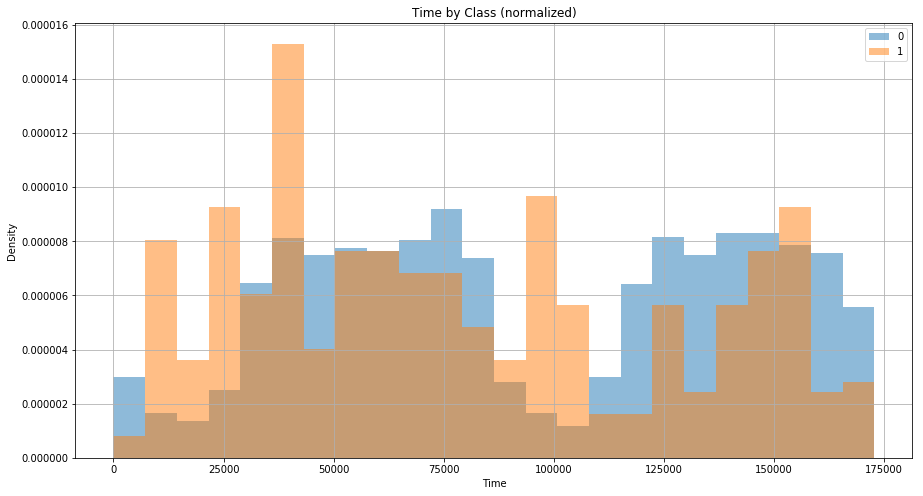

In [20]:
multiple_histograms_plot(df_train, x='Time', hue='Class', bins=time_bins,
                         title="Distribuição de 'Time' (normalizada)",
                         density=True)

In [21]:
day_1_daytime_start = time_bins[4]
day_1_daytime_end = time_bins[12]

day_2_daytime_start = time_bins[16]
day_2_daytime_end = time_bins[24]

In [22]:
def add_daytime_col(dataframe):
    df_copy = dataframe.copy()
    
    df_copy['Time_daytime'] = (((df_copy['Time'] >= day_1_daytime_start) 
                                  & (df_copy['Time'] <= day_1_daytime_end))
                               | ((df_copy['Time'] >= day_2_daytime_start) 
                                  & (df_copy['Time'] <= day_2_daytime_end))).astype(int)
    
    return df_copy

In [23]:
df_train = add_daytime_col(df_train)

/Users/gabrielcs/anaconda/envs/tera-out2018/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


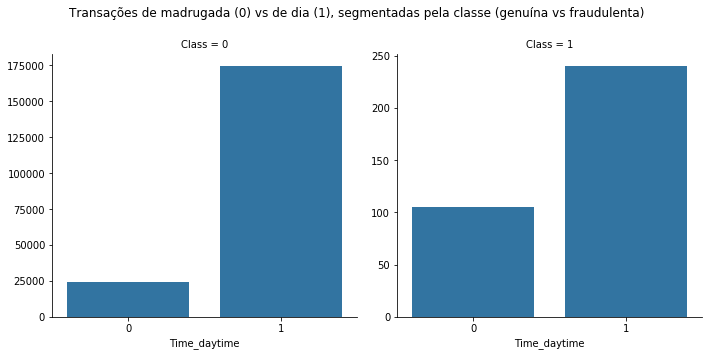

In [24]:
countplot_independent_ylims(df_train, col='Time_daytime', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações de madrugada (0) vs de dia (1), '
                                  'segmentadas pela classe (genuína vs fraudulenta)')

É possível ver acima que a proporção de transações fraudulentas no que julgamos ser o período da madrugada parece ser maior do que o normal.

### Amount

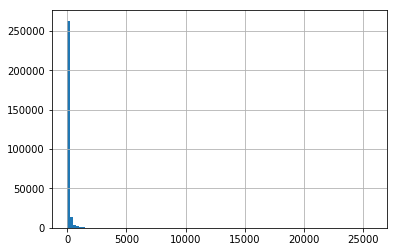

In [25]:
df['Amount'].hist(bins=100)

In [26]:
high_transactions = df['Amount'] > 1500

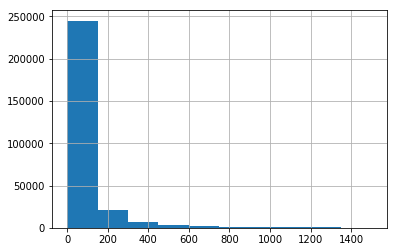

In [27]:
df.loc[~high_transactions, 'Amount'].hist()

É possível que uma transformação de log funcione bem para `Amount`. 

Antes disso, vamos verificar se existem valores comuns em caso de fraude.

In [28]:
fraud = df_train['Class'] == 1

In [29]:
(df_train.loc[fraud, 'Amount']
     .value_counts()
     .sort_values(ascending=False)
     .head(15))

1.00      66
99.99     21
0.00      20
0.76      12
0.77       7
3.79       4
1.10       3
0.01       3
1.59       2
1.52       2
30.31      2
101.50     2
104.03     2
723.21     2
252.92     2
Name: Amount, dtype: int64

Vamos comparar as proporções desses 3 valores mais comuns com as transações genuinas.

In [30]:
def add_amount_cols(dataframe):
    df_copy = dataframe.copy()
    df_copy['Amount_1'] = df_copy['Amount'] == 1
    df_copy['Amount_99_99'] = df_copy['Amount'] == 99.99
    df_copy['Amount_0'] = df_copy['Amount'] == 0
    return df_copy

In [31]:
df_train = add_amount_cols(df_train)

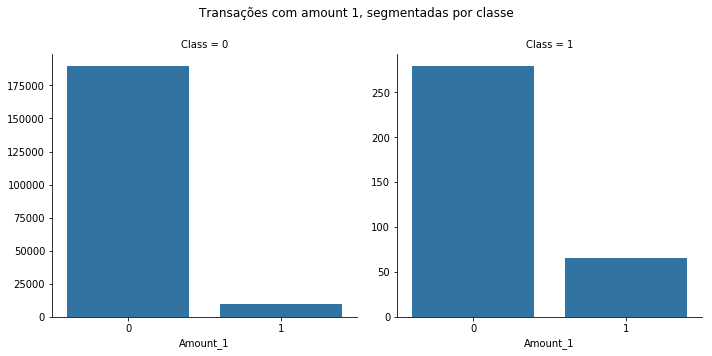

In [32]:
countplot_independent_ylims(df_train, col='Amount_1', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações com amount 1, '
                                  'segmentadas por classe')

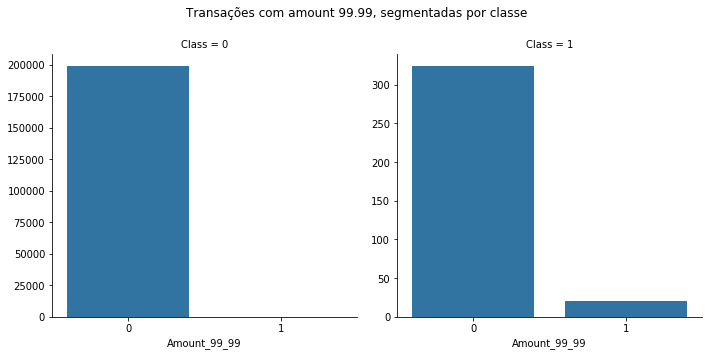

In [33]:
countplot_independent_ylims(df_train, col='Amount_99_99', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações com amount 99.99, '
                                  'segmentadas por classe')

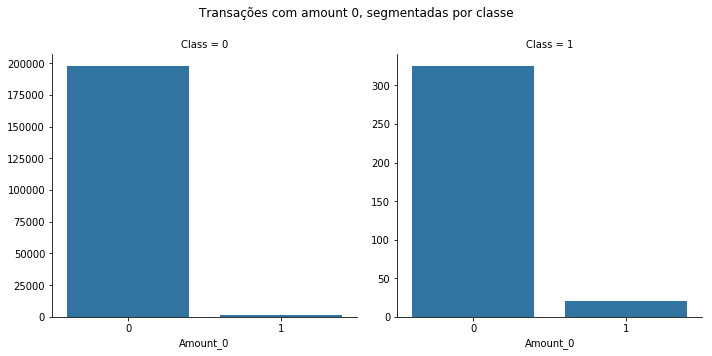

In [34]:
countplot_independent_ylims(df_train, col='Amount_0', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações com amount 0, '
                                  'segmentadas por classe')

Vamos manter essas 3 features - elas podem ser úteis.

No mais, apesar de estranho, temos transações de valor zero tanto em transações genuínas quanto em fraudes. Dessa forma, aplicaremos o log somente para efeito de visualização.

De qualquer forma, vamos observar os valores `log(99.99)` e `log(1)=0`.

In [35]:
np.log(99.99)

4.605070180987758

In [36]:
amount_0 = df_train['Amount_0']
df_train['Amount_log'] = np.log(df_train.loc[~amount_0, 'Amount'])

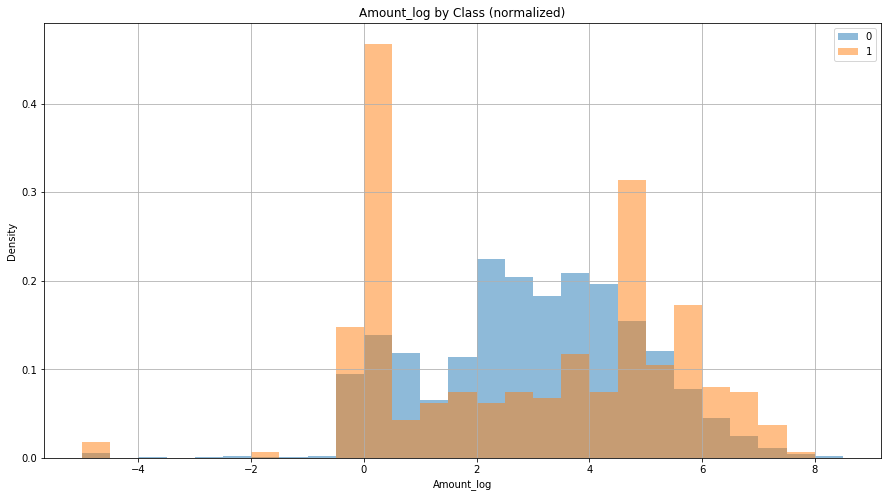

In [37]:
multiple_histograms_plot(df_train, x='Amount_log', hue='Class', density=True,
                         title="Distribuição de 'Amount' (normalizada)",
                         bins=np.arange(-5, 9, 0.5))

### Features anonimizadas

/Users/gabrielcs/anaconda/envs/tera-out2018/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


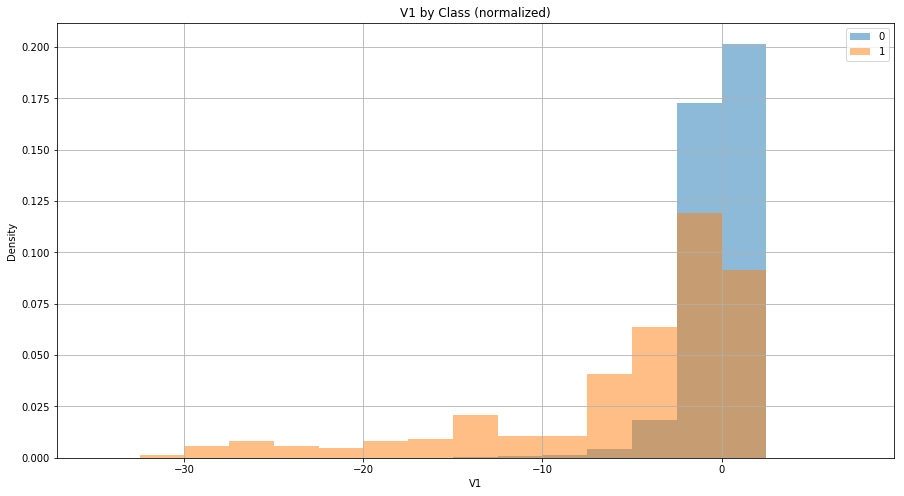

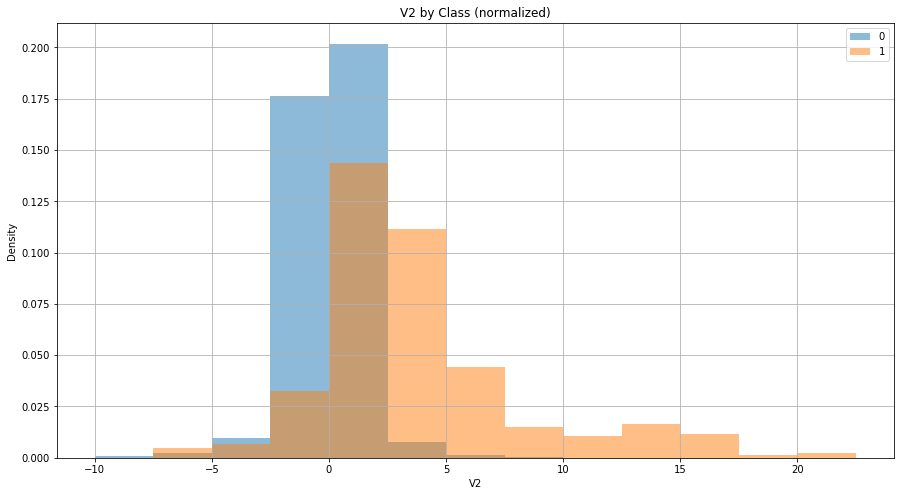

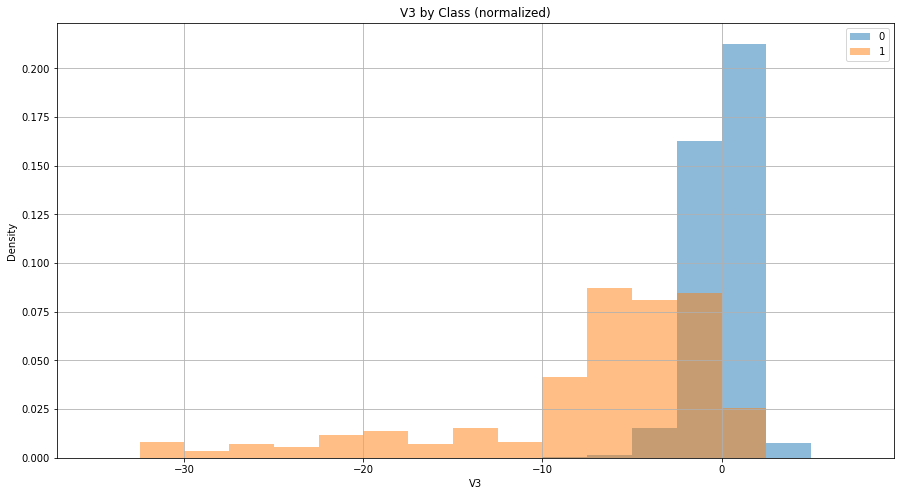

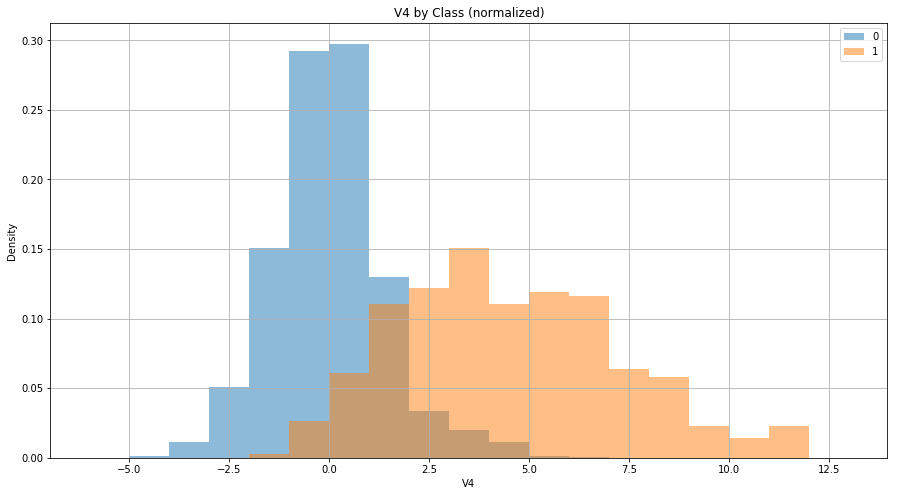

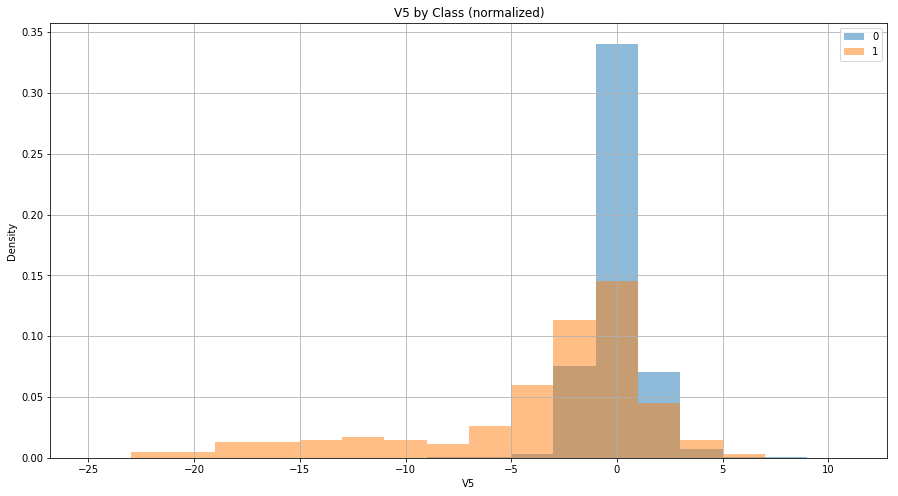

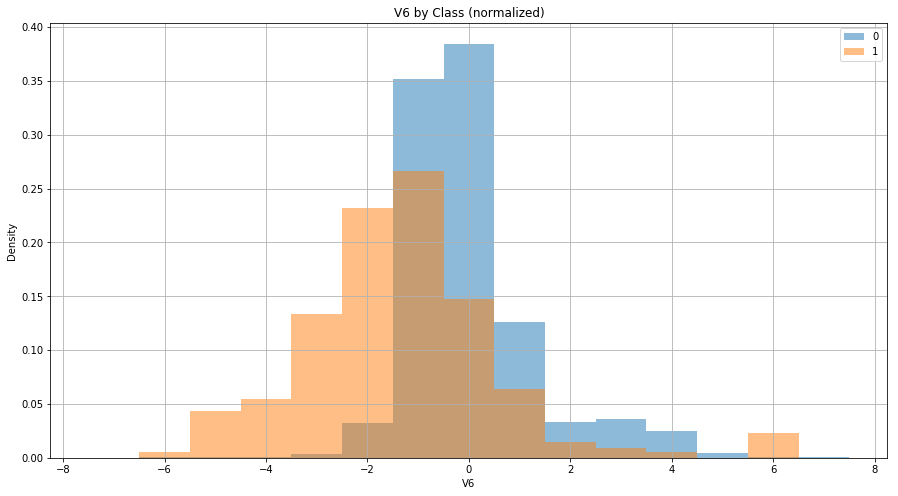

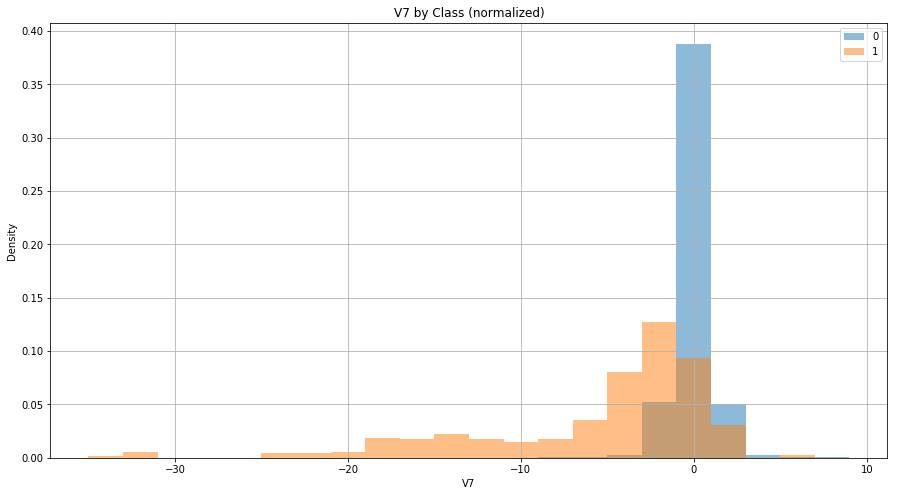

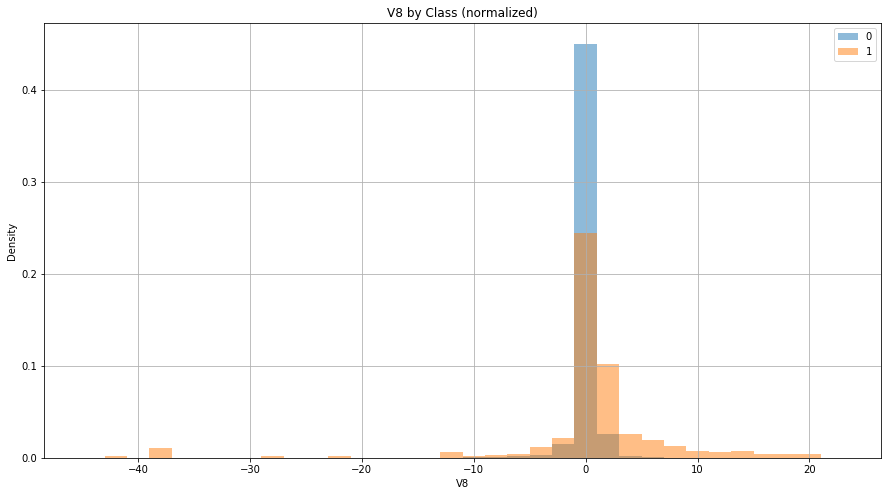

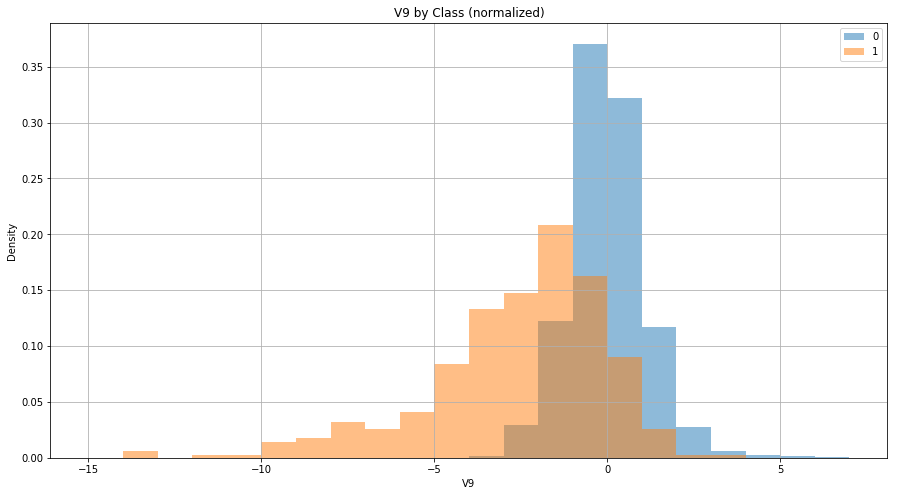

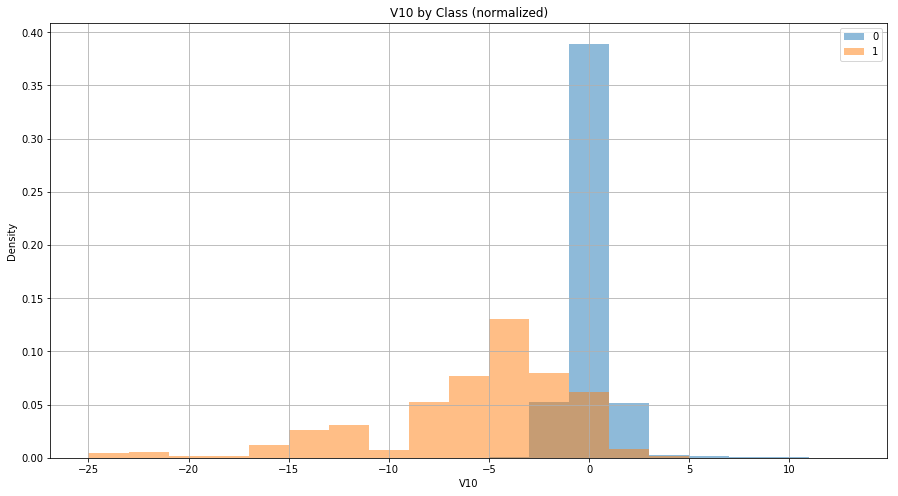

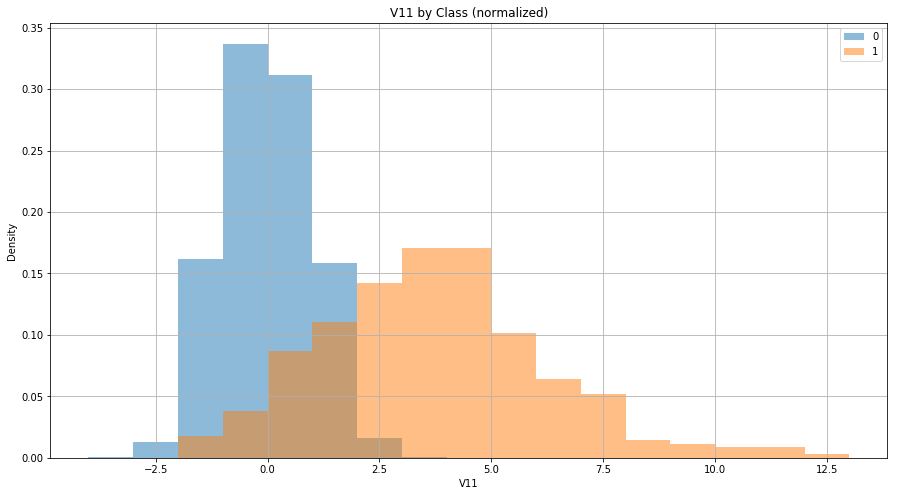

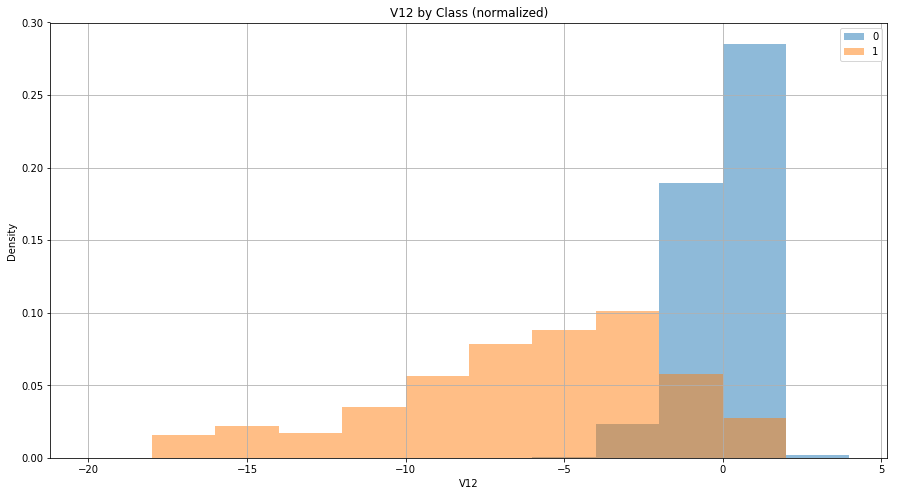

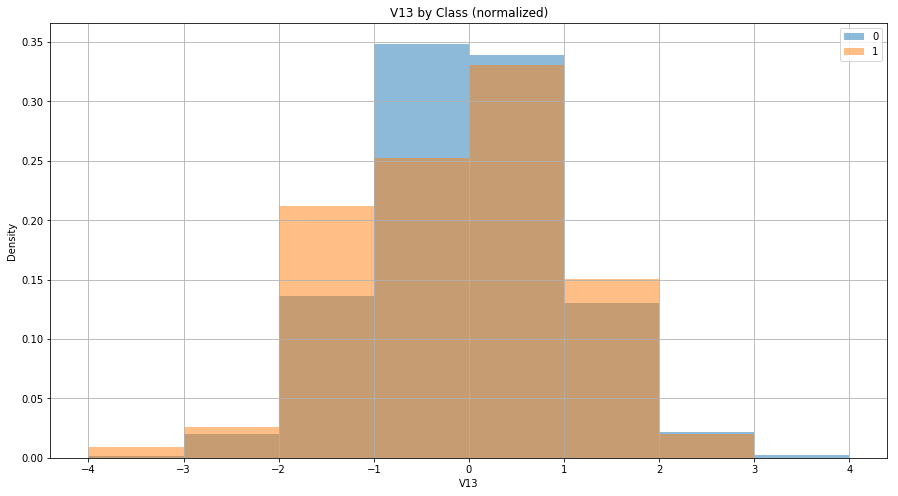

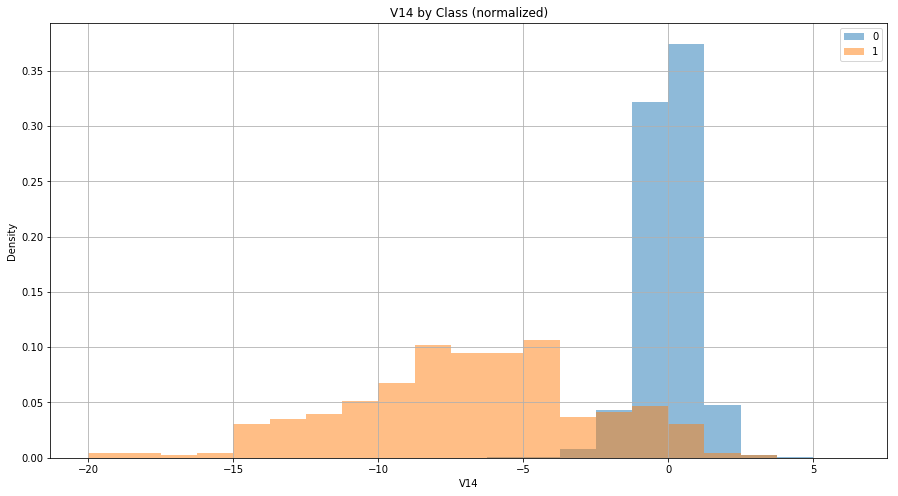

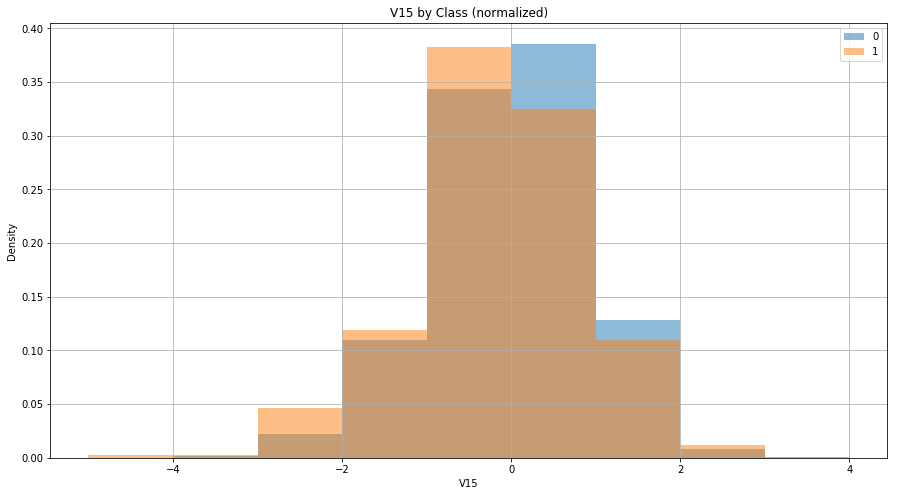

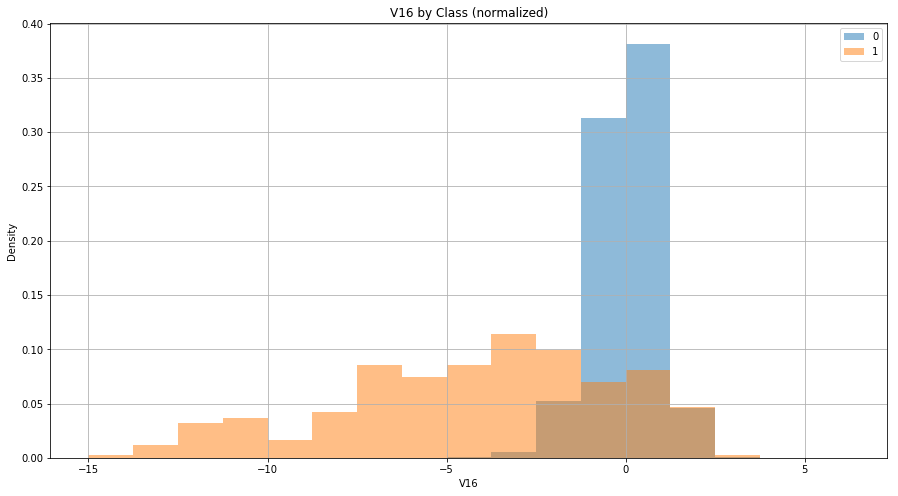

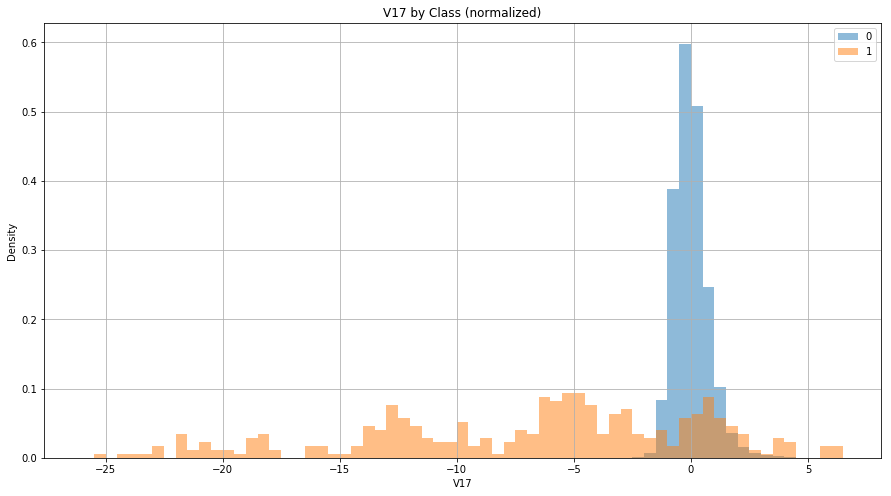

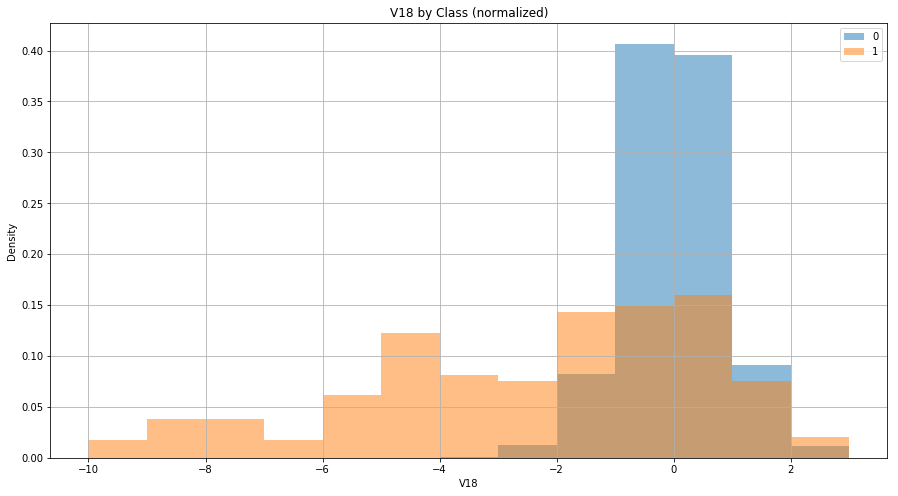

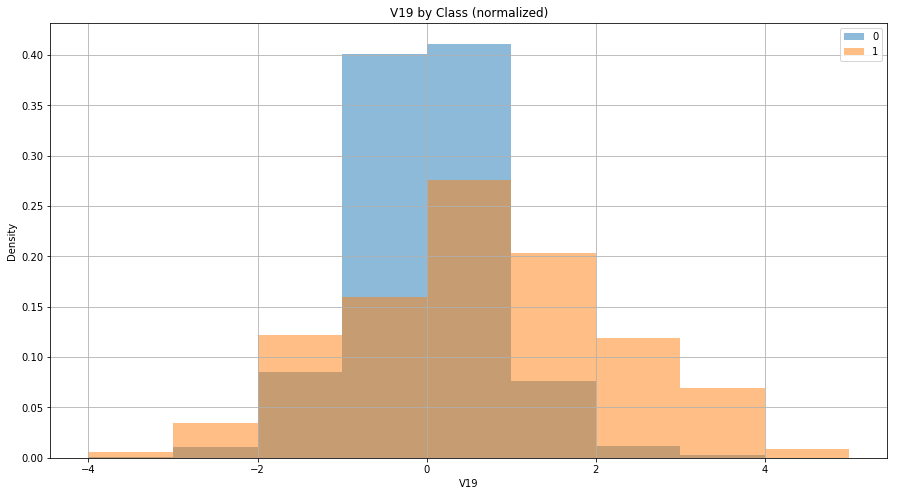

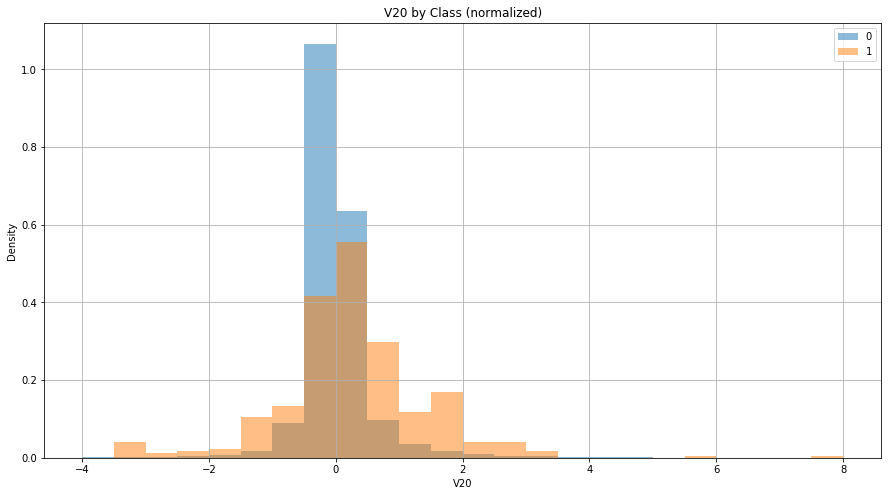

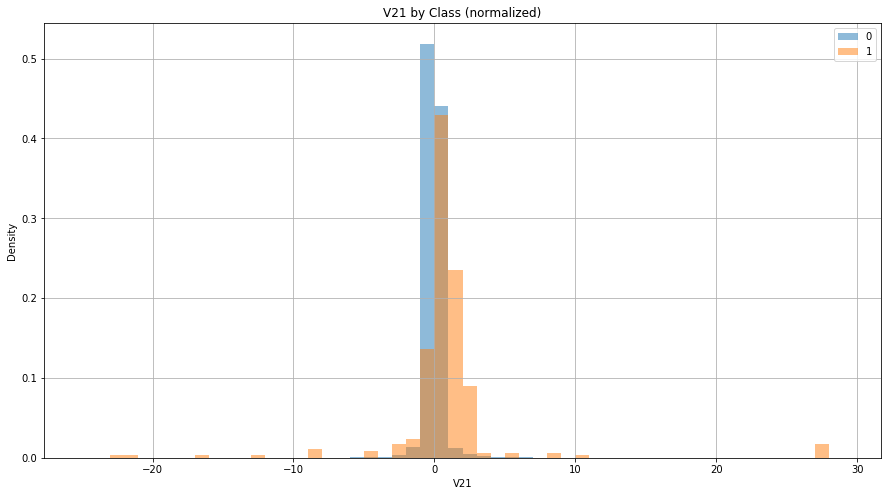

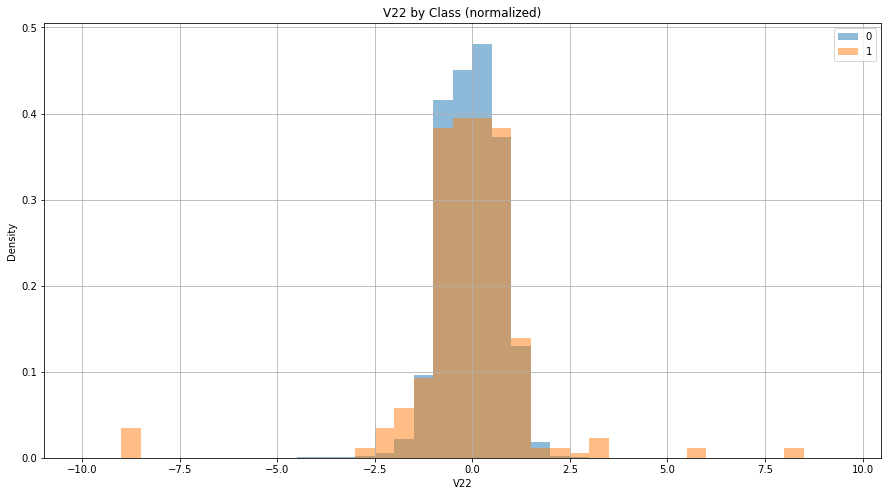

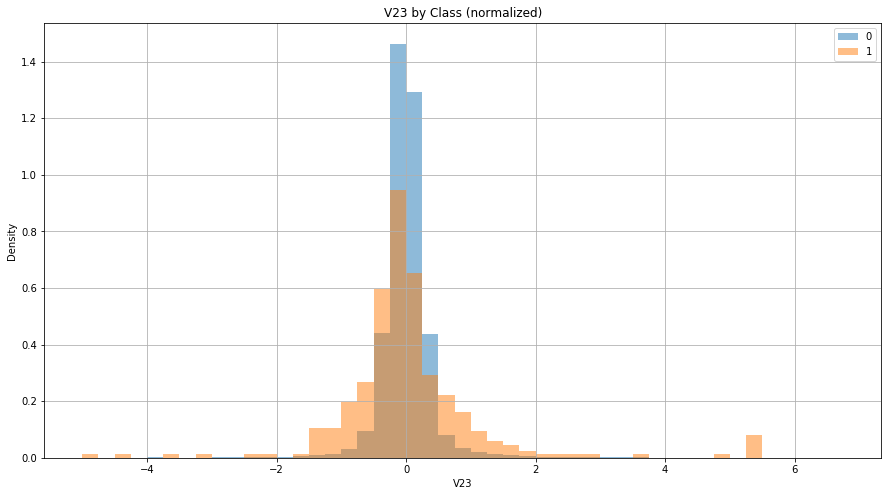

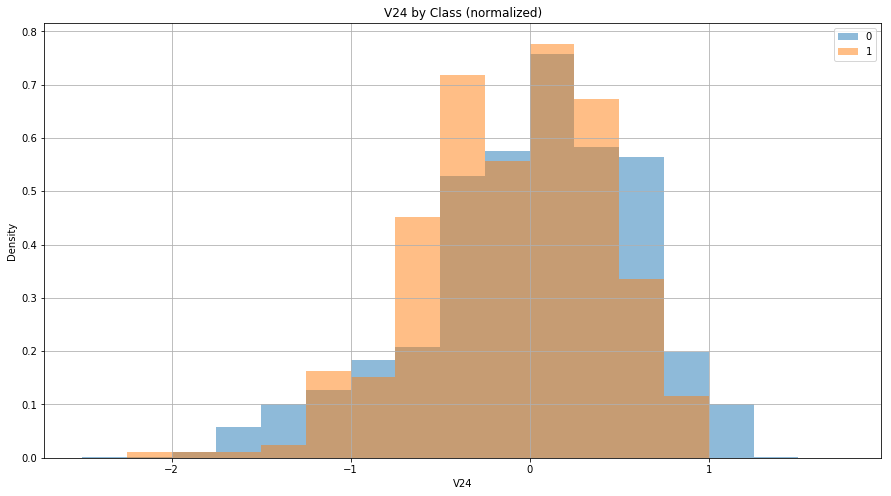

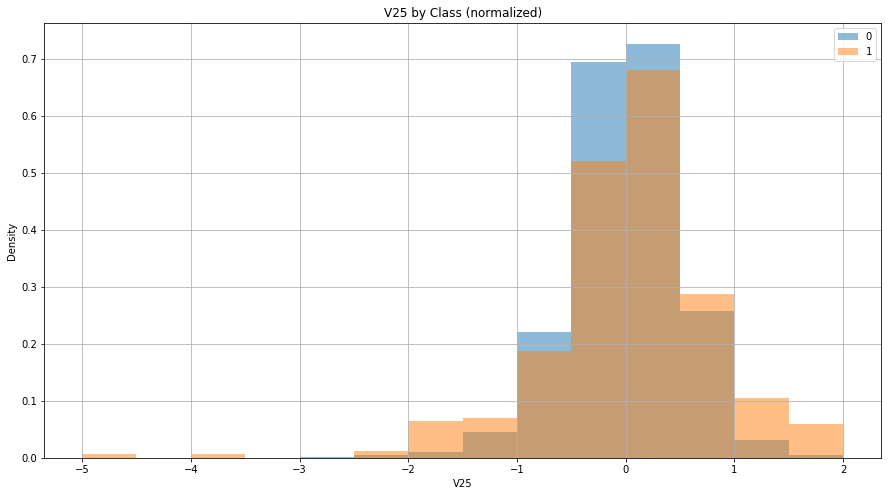

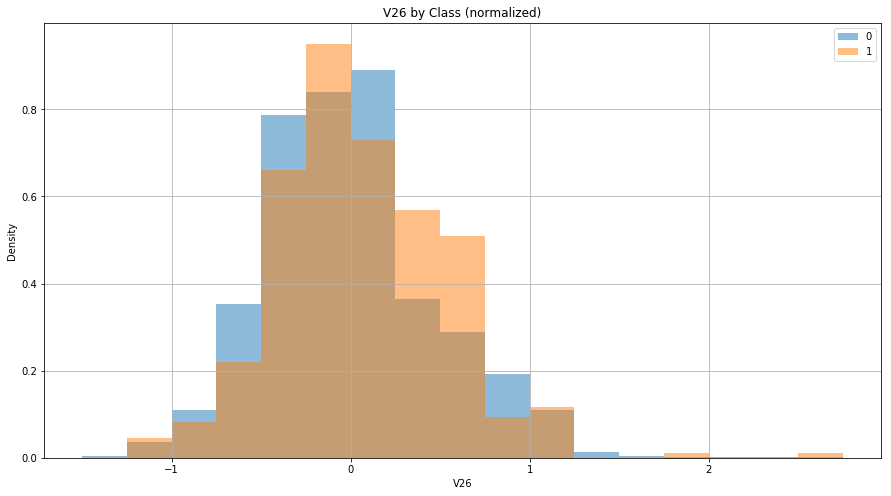

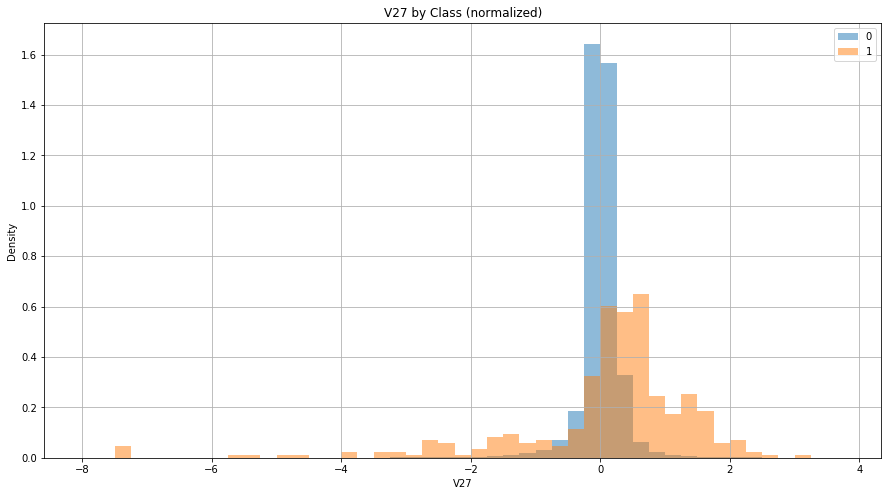

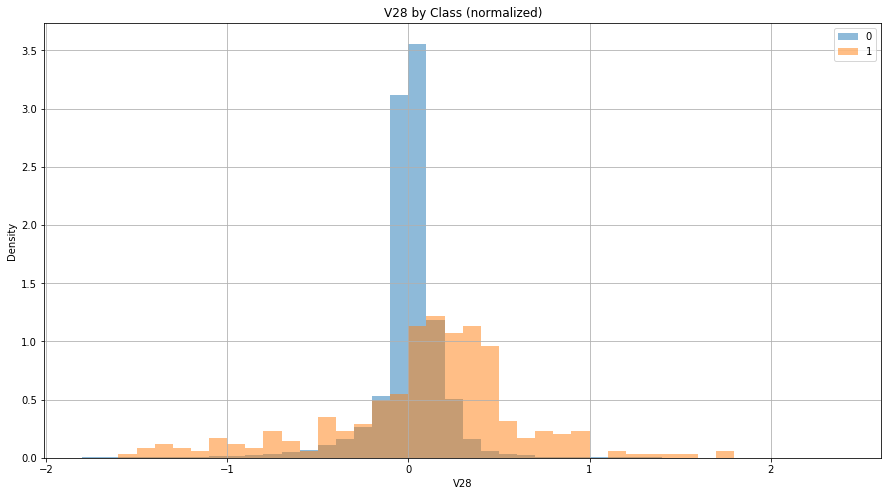

In [38]:
bins_list = [
    np.arange(-35, 10, 2.5), #v1
    np.arange(-10, 25, 2.5), #v2
    np.arange(-35, 10, 2.5), #v3
    np.arange(-6, 14, 1), #v4
    np.arange(-25, 12, 2), #v5
    np.arange(-7.5, 8.5, 1), #v6
    np.arange(-35, 11, 2), #v7
    np.arange(-45, 25, 2), #v8
    np.arange(-15, 8, 1), #v9
    np.arange(-25, 15, 2), #v10
    np.arange(-4, 14, 1), #v11
    np.arange(-20, 6, 2), #v12
    np.arange(-4, 5, 1), #v13
    np.arange(-20, 7.5, 1.25), #v14
    np.arange(-5, 5, 1), #v15
    np.arange(-15, 7.5, 1.25), #v16
    np.arange(-26, 7, 0.5), #v17
    np.arange(-10, 4, 1), #v18
    np.arange(-4, 6, 1), #v19
    np.arange(-4, 8.5, 0.5), #v20
    np.arange(-25, 30, 1), #v21
    np.arange(-10, 10, 0.5), #v22
    np.arange(-5, 7, 0.25), #v23
    np.arange(-2.5, 2, 0.25), #v24
    np.arange(-5, 2.5, 0.5), #v25
    np.arange(-1.5, 3, 0.25), #v26
    np.arange(-8, 4, 0.25), #v27
    np.arange(-1.8, 2.5, 0.1), #v28
]

for var, bins in zip(range(1, len(bins_list)+1), bins_list):
    multiple_histograms_plot(df_train, x=f'V{var}', hue='Class',
                             bins=bins, density=True,
                             title=f"Distribuições de 'V{var}', "
                                    "segmentadas por 'Class' e normalizadas")

Podemos ver acima que algumas variáveis parecem ter mais poder preditivo do que outras.

Vamos seguir para a modelagem.

## Pipeline de pré-processamento

Antes de treinar o modelo e fazer predições, vamos aplicar as transformações nos dados que julgamos úteis na seção anterior.

Obs.: como nós fizemos os testes em `df_train`, `X_train` não foi modificado e também precisará passar pelo pré-processador.

In [39]:
pre_processor = make_pipeline(FunctionTransformer(time_to_int, validate=False),
                              FunctionTransformer(add_daytime_col, validate=False),
                              FunctionTransformer(add_amount_cols, validate=False))

In [40]:
X_train = pre_processor.fit_transform(X_train)
X_test = pre_processor.fit_transform(X_test)

Obs.: se somente utilizamos algoritmos baseados em árvores, o pré-processador pode não trazer grandes melhorias. Essas transformações são provavelmente mais efetivas se utilizados algoritmos lineares. Por outro lado, para algoritmos lineares, é recomendado analisar colinearidade entre features, tratar outliers e normalizar/padronizar os dados.

In [41]:
df_train = pd.concat([X_train, y_train], axis='columns')
df_test = pd.concat([X_test, y_test], axis='columns')

In [42]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_daytime,Amount_1,Amount_99_99,Amount_0,Class
161145,113921,-0.13,0.11,-0.65,-1.00,1.81,1.74,0.50,0.63,0.02,-0.36,0.53,0.51,-0.74,0.49,-0.16,-0.95,0.26,-1.76,-0.94,-0.06,-0.06,0.01,0.25,-2.47,-0.89,0.34,0.31,0.07,47.89,0,False,False,False,0
204520,135319,2.13,0.01,-1.51,0.12,0.60,-0.33,0.20,-0.26,0.38,0.03,-1.21,0.84,1.51,-0.04,-0.00,0.08,-0.66,-0.75,0.43,-0.09,-0.33,-0.79,0.27,0.07,-0.14,0.20,-0.07,-0.06,1.98,1,False,False,False,0
182659,125498,-0.09,0.17,1.57,0.69,0.22,1.10,1.58,-1.10,0.76,1.40,1.35,0.14,0.16,-1.15,0.66,-0.13,-1.27,0.82,0.41,0.05,0.02,1.06,-0.41,0.72,-0.17,-0.61,-1.20,-1.14,170.10,1,False,False,False,0
25117,33520,1.35,-0.53,0.56,-0.63,-1.14,-0.85,-0.64,-0.03,-0.65,0.62,0.10,-1.07,-1.23,0.20,1.15,0.85,0.71,-1.96,0.13,-0.07,-0.01,-0.18,0.18,0.35,0.15,-0.40,0.01,0.02,5.96,1,False,False,False,0
227642,145152,-1.53,0.65,0.62,-0.56,0.84,-0.51,0.98,-0.10,-0.06,-1.03,-0.71,-0.61,-0.34,-1.38,0.31,0.55,0.51,0.37,-0.16,-0.07,-0.22,-0.39,-0.21,0.59,0.68,0.52,0.07,0.15,89.95,1,False,False,False,0


In [44]:
df_train.to_csv('../data/train.csv', index=False)
df_test.to_csv('../data/test.csv', index=False)